In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers

import string
import re

import preprocess_text as pt


from pandarallel import pandarallel
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [2]:
import gc

gc.collect()

7

In [3]:
train_df,val_df = pt.suicidal_intent_data_load(test_dataset=False,standardization=False)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [4]:

pandarallel.initialize()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [5]:
def stemmer_parallel(input):
    import nltk
    stemmer = nltk.SnowballStemmer("english")
    return ' '.join([stemmer.stem(word) for word in input.split(' ')])

In [6]:
train_df["text"] = train_df["text"].parallel_apply(stemmer_parallel)
val_df["text"] = val_df["text"].parallel_apply(stemmer_parallel)

In [7]:
SQ_LEN = train_df["text"].apply(lambda x: len(x.split()))

In [8]:
val_SQ_LEN = val_df["text"].apply(lambda x: len(x.split()))

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 1600x1000 with 0 Axes>

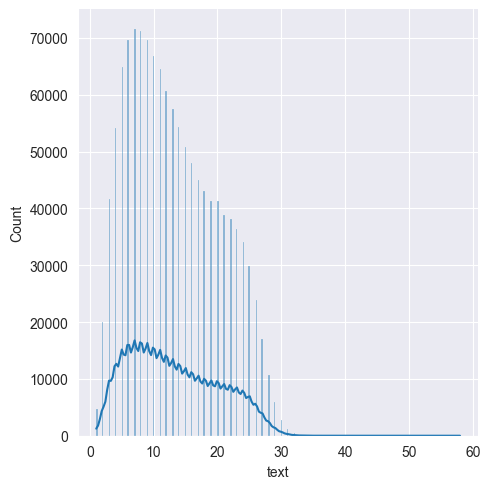

In [10]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,10))
sns.displot(SQ_LEN, kde=True)

<Figure size 1600x1000 with 0 Axes>

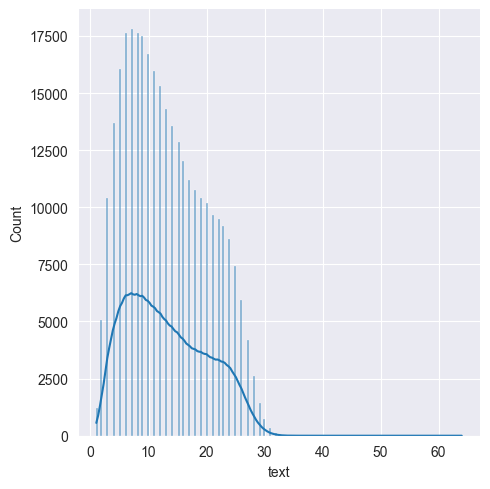

In [11]:
plt.figure(figsize=(16,10))
sns.displot(val_SQ_LEN, kde=True)

In [12]:
max_length = SQ_LEN.max()
max_length

58

In [13]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dataframe["text"].values, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [14]:
raw_train_ds = df_to_dataset(train_df)
raw_val_ds = df_to_dataset(val_df)


print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")


Number of batches in raw_train_ds: 40000
Number of batches in raw_val_ds: 10000


In [15]:
for feature_batch,label_batch in raw_train_ds.take(1):
    print("feature:",feature_batch) 
    print("label:",label_batch)

feature: tf.Tensor(
[b'i miss her alot and it onli been one day '
 b"can't do anyth right today... i'm log off befor anyth els happen *veri sad* "
 b'@kissmybleep she post something? i will. '
 b"@librarykri yeah, don't usual do cut out biscuits. will have to fudg cooki cutter. espresso cup are about the right size, eh? "
 b'mais...mais...gregwar ne me suit pas sur twitter  '
 b'@badassyella your welcom '
 b'@hardeepdeepdeep how come your not do a book sign in glasgow ? that not fair! '
 b'@craigfl damn... they remov them from the old one '
 b'thank everyon for the birthday wishes! i realli do hope i get a new laptop for college! i do need one '
 b'@parisgraph ani idea how much entri is? $10 i hope? '
 b'@sarahkelly58 becaus im the best at negotiating! '
 b'back from meet my best friend english-exchangepartn '
 b'my dad has bern diagnos with what may br vertigo. '
 b'mum and dad is com home from totn today '
 b'@delbius thank for restor  appreci it.'
 b"@gchanc it doesn't take much, do

In [16]:
class Patterns:
    URL_PATTERN_STR = r"^((https?|ftp|smtp):\/\/)?(www.)?[a-z0-9]+\.[a-z]+(\/[a-zA-Z0-9#]+\/?)*$"
    HASHTAG_STR = r'#\w*'
    MENTION_STR = r'@\w*'
    EMOJIS_STR = u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])'
    SMILEYS_STR = r"(\s?:X|:|;|=)(?:-)?(?:\)+|\(|O|D|P|S|\\|\/\s){1,}"
    NUMBERS_STR = r"(^|\s)(-?\d+([.,]?\d+)*)"
    PUNCTUATION_STR = r"[^\w\s]"

def custom_standardizer(input):
    lowercase = tf.strings.lower(input)
    processed = tf.strings.regex_replace(lowercase, Patterns.URL_PATTERN_STR, "")
    processed = tf.strings.regex_replace(processed, Patterns.HASHTAG_STR, "")
    processed = tf.strings.regex_replace(processed, Patterns.MENTION_STR, "")
    processed = tf.strings.regex_replace(processed, Patterns.EMOJIS_STR, "")
    processed = tf.strings.regex_replace(processed, Patterns.SMILEYS_STR, "")
    processed = tf.strings.regex_replace(processed, Patterns.NUMBERS_STR, "")
    processed = tf.strings.regex_replace(processed, Patterns.PUNCTUATION_STR, "")
    return processed

In [17]:
# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

vectorize_layer = TextVectorization(
    standardize=custom_standardizer,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [18]:
text_ds = raw_train_ds.map(lambda x, y: x)

In [19]:
vectorize_layer.adapt(text_ds)

In [20]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)


# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)


In [21]:
for feature_batch,label_batch in train_ds.take(1):
    print("feature:",feature_batch) 
    print("label:",label_batch)

feature: tf.Tensor(
[[ 154  204    9 ...    0    0    0]
 [2643  178    0 ...    0    0    0]
 [   1    1   81 ...    0    0    0]
 ...
 [ 971   20   16 ...    0    0    0]
 [  90    4   54 ...    0    0    0]
 [8538  168   29 ...    0    0    0]], shape=(32, 500), dtype=int64)
label: tf.Tensor([0 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1], shape=(32,), dtype=int32)


In [22]:
train_ds.save("model_checkpoints/neural_net/train_data")
val_ds.save("model_checkpoints/neural_net/val_data")

In [23]:
del raw_train_ds,raw_val_ds,train_df,val_df,train_ds,val_ds,text_ds
gc.collect()

1248

In [24]:
train_ds = tf.data.Dataset.load("model_checkpoints/neural_net/train_data")
val_ds = tf.data.Dataset.load("model_checkpoints/neural_net/val_data")

In [25]:
max_features = 20000
embedding_dim = 128
sequence_length = 500
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"],run_eagerly=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint("model_outputs/neural_net/best_model",save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         114816    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                             

In [27]:
epochs = 10
# Fit the model using the train and test datasets.
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
40000/40000 [==============================] - 1402s 35ms/step - loss: 0.4438 - accuracy: 0.7964 - val_loss: 0.4197 - val_accuracy: 0.8094
Epoch 2/10
40000/40000 [==============================] - 1395s 35ms/step - loss: 0.4156 - accuracy: 0.8134 - val_loss: 0.4101 - val_accuracy: 0.8119
Epoch 3/10
40000/40000 [==============================] - 1390s 35ms/step - loss: 0.4066 - accuracy: 0.8187 - val_loss: 0.4100 - val_accuracy: 0.8132
Epoch 4/10
40000/40000 [==============================] - 1392s 35ms/step - loss: 0.4007 - accuracy: 0.8219 - val_loss: 0.4050 - val_accuracy: 0.8155
Epoch 5/10
40000/40000 [==============================] - 1397s 35ms/step - loss: 0.3967 - accuracy: 0.8249 - val_loss: 0.4063 - val_accuracy: 0.8170
Epoch 6/10
40000/40000 [==============================] - 1393s 35ms/step - loss: 0.3927 - accuracy: 0.8270 - val_loss: 0.4138 - val_accuracy: 0.8145
Epoch 7/10
40000/40000 [==============================] - 1393s 35ms/step - loss: 0.3890 - accuracy:

In [28]:
test_df = pd.DataFrame({"text":["I kill myself"],"target":[1]})

In [29]:
test_df["text"] = test_df["text"].parallel_apply(stemmer_parallel)

In [30]:
new_test_ds = df_to_dataset(test_df)

In [31]:
# A string input
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorize_layer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
end_to_end_model.predict(new_test_ds)

1/1 [==============================] - 0s 237ms/step


array([[0.9370176]], dtype=float32)

In [32]:
end_to_end_model.save('model_outputs/neural_net')

INFO:tensorflow:Assets written to: model_outputs/neural_net\assets


INFO:tensorflow:Assets written to: model_outputs/neural_net\assets
